In [20]:
import flopy ; import sys ; import pathlib ; import os ; import time ; import numpy as np ; import matplotlib.pyplot as plt; from math import pi;  
from copy import deepcopy as deepcopy; from scipy.special import erfc as erfc; from scipy.special import erf as erf; import pandas as pd
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\w10_______others\\06_MT3D_Wisconsin-Madison\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\d03_Beta-Me\04_Wisconsin-Madison\07


In [3]:
path = pathlib.Path('E:\\15_REPOS\\d03_Beta-Me\\04_Wisconsin-Madison\\07')
path.mkdir(parents=True, exist_ok=True)  ; os.chdir(path)  ;   current_directory = os.getcwd() # print(current_directory)
directory_name = 'backdiff'
workdir = os.path.join('.', directory_name)
if os.path.isdir(workdir) is False:
    os.mkdir(workdir)                       # print("Directory '% s' created" % workdir) 
datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')  # See ?

In [4]:
def plot_2d(map_data, dx, dy, colorbar_label=''  , cmap='cividis', title='', clim=0):                           # FUNCTION_01
    r, c   = np.shape   (map_data)               ; x_coord = np.linspace(0, dx*c, c+1);  y_coord = np.linspace(0, dy*r, r+1);  
    X,Y    = np.meshgrid(x_coord, y_coord)       ; plt.figure(figsize=(3, 1), dpi = 150 )
    plt.pcolormesh(X, Y, map_data, cmap=cmap,    shading = 'auto', edgecolor ='k', linewidth = 0.001)
    plt.gca().set_aspect('equal')                ; cbar = plt.colorbar()                                ; cbar.set_label(colorbar_label)
    if clim != 0:
        plt.clim(clim)
    plt.xlabel('Distance [m]')                   ; plt.tick_params(axis='both', which='major')     ; plt.xlim((0, dx*c)) 
    plt.ylim((0, dy*r));     plt.title(title)    ; plt.show()

In [ ]:
nlay = 40; nrow = 1; ncol = 120                             ; delv = 0.01; delr = 0.01 ; delc = 0.03 ;     
material_location = np.zeros([nlay, nrow, ncol])            ; material_location [10:20,:, 15:-15] = 1             
sec2day = 86400                                             ; ksand = 2.4e-4*sec2day; kclay = 1e-10*sec2day     
Hk = np.ones([nlay, nrow, ncol]) * ksand                    ; Hk[material_location==1] = kclay
por_sand = 0.4 ; por_clay = 0.5                             ; Por = np.ones([nlay, nrow, ncol]) * por_sand   
Por[material_location==1] = por_clay                        ; PV  = Por*delr*delc*delv ; tank_pv = np.sum(PV); print('Tank pore vol %f m^3' %tank_pv)
# plot_2d(np.squeeze(material_location), delr, delv, cmap='PiYG')
# plot_2d(np.squeeze(Hk),                delr, delv, cmap='viridis', colorbar_label = 'K [m/day]')   
plot_2d(np.squeeze(Por),                 delr, delv, colorbar_label = 'Porosity [-]') 

In [6]:
def model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv):
    
    model_ws = os.path.join(workdir, dirname)                  ; print(model_ws)   
    itmuni   = 4               ; mt_tunit = 'D'                ; lenuni = 2                ; mt_lunit = 'M'      ; al = 0.01; trpv = 0.001/al
    perlen_mf = perlen_mt      ; nper_mf  = len(perlen_mf)     ; nper   = len(perlen_mt)   ; nprs     = nprs
    timprs    = np.linspace(0, np.sum(perlen_mf), nprs, endpoint = False)                  ; hk_size  = Hk.shape
    nlay = hk_size[0]          ; nrow = hk_size[1]             ;  ncol = hk_size[2]        ; botm = -np.linspace(delv, delv*nlay, nlay)
    
    ibound         = np.ones((nlay, nrow, ncol), dtype=int)    ;  ibound[:, :, -1] = -1    ; strt = np.zeros((nlay, nrow, ncol), dtype=float)
    well_info      = np.zeros((nlay, 4),dtype=float); 
    well_info[:,0] = range(0, nlay) 
    well_info[:,3] = Q[0] / (nrow * nlay)                      ; w = deepcopy(well_info)   ; spd_mf = { 0 : w }
    for i in range(1, nper):
        if isinstance(Q, (list, tuple, np.ndarray)):             
            well_info[:,3] = Q[i] / (nrow * nlay)
        else:
            well_info[:,3] = Q / (nrow * nlay)                 ; w = deepcopy(well_info)   ; spd_mf.update({i:w})  

    icbund          = np.ones((nlay, nrow, ncol), dtype=int)                               ; sconc = np.zeros((nlay, nrow, ncol), dtype=float) 
    cwell_info      = np.zeros((int(nlay), 5), dtype=float)                         
    cwell_info[:,0] = range(0, nlay);  
    cwell_info[:,3] = Cinj[0]                                  ; itype = 2
    cwell_info[:,4] = int(itype)                               ; cw = deepcopy(cwell_info) ; spd_mt = { 0 : cw }
    for i in range(1,nper):
        if isinstance(Cinj, (list, tuple, np.ndarray)):
            cwell_info[:,3] = Cinj[i]                    
        else:
            cwell_info[:,3] = Cinj                             ; cw = deepcopy(cwell_info) ; spd_mt.update({i:cw})  
    
    modelname_mf = dirname + '_mf' ;
    mf  = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf,  nlay = nlay, nrow=nrow, ncol=ncol, nper=nper_mf, delr=delr, delc=delc, top=0., botm = botm,
                                   perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=Hk, laytyp=0)
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=spd_mf)
    pcg = flopy.modflow.ModflowPcg(mf, rclose=1.0e-5, mxiter=100, iter1=50)
    lmt = flopy.modflow.ModflowLmt(mf)
    spd = {(0, 0): ['save head'], (0, 1): ['save head'], (0, 2): ['save head'], (0, 3): ['save head']}
    oc  = flopy.modflow.ModflowOc(mf, stress_period_data=spd) ;  mf.write_input();   mf.run_model(silent=True);  
    
    modelname_mt = dirname + '_mt'    
    mt  = flopy.mt3d.Mt3dms(modelname=modelname_mt, model_ws=model_ws, exe_name=exe_name_mt, modflowmodel=mf)  
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=Por, sconc=sconc, tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)              ;                                    mixelm = -1
    adv = flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm)
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpv =trpv, dmcoef=D0)                        # dmcoef  dispesion..difusion
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd_mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)                                                      ;     mt.write_input()
    
    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    fname = os.path.join(model_ws, 'MT3D001.UCN') ;    ucnobj = flopy.utils.UcnFile(fname)
    times = np.array(ucnobj.get_times());                conc = ucnobj.get_alldata()
    
    h = flopy.utils.HeadFile(os.path.join(model_ws, modelname_mf+'.hds'), model=mf)
    htimes = h.times;                                    fname = os.path.join(model_ws, modelname_mf+'.hds')
    hdobj = flopy.utils.HeadFile(fname);                 heads = hdobj.get_data()
    
    if len(times) != nprs+len(perlen_mt):
        print('The model output has {} timesteps, the model input requested {} timesteps. Simulation may have terminated early'.format(len(times), nprs+len(perlen_mt)))
    else:
        print('Simulation ran to requested model time.')         ;           return heads, htimes, conc, times

In [7]:
sf = nlay * delv / 0.84;    nper = 3;    Q = np.array([0.9, 1.5, 1.5]) * (60*24/100**3) * sf;  Cinj = [1, 0, 0]

ibound = np.ones((nlay, nrow, ncol), dtype=int)  ; ibound[:, :, -1] = -1         ; print('ibound',ibound.shape)
iB     = ibound[:,0,:];  cr = pd.DataFrame(iB)                                   ; print('bound_2D',cr.shape)    ; cr.to_csv ("07c__(ibound).csv") 
well_info       = np.zeros((nlay, 4),dtype=float)  ; print('W', well_info.shape) ; cr = pd.DataFrame(well_info)  ; cr.to_csv ("07d(W_info).csv")
well_info[:,0]  = range(0, nlay)                                                 ; cr = pd.DataFrame(well_info)  ; cr.to_csv ("07e(W_info).csv")
well_info[:,3]  = Q[0] / (nrow * nlay)                                           ; cr = pd.DataFrame(well_info)  ; cr.to_csv ("07f(W_info).csv")
for i in range(1, nper):
    if isinstance(Q, (list, tuple, np.ndarray)):
        well_info[:,3] = Q[i] / (nrow * nlay)
    else:
        well_info[:,3] = Q / (nrow * nlay)                                       ; # cr = pd.DataFrame(well_info)  ; cr.to_csv ("07g(W_info).csv")  
     
cwell_info      = np.zeros((int(nlay), 5), dtype=float)                          ; print('cW', cwell_info.shape)
cwell_info[:,0] = range(0, nlay)                                                 ; cr = pd.DataFrame(cwell_info) ; cr.to_csv ("07h__(W_info_C).csv")
cwell_info[:,3]  = Cinj[0]                                                       ; cr = pd.DataFrame(cwell_info) ; cr.to_csv ("07i__(W_info_C).csv") 

ibound (40, 1, 120)
bound_2D (40, 120)
W (40, 4)
cW (40, 5)


In [8]:
dirname = 'Chapman_model'   ;     perlen_mt = [10, 22, 50]       ;            nprs = 100  # 165
sf = nlay * delv / 0.84        # scale factor based on height of model relative to tank in Chapman paper
Q = np.array([0.9, 1.5, 1.5]) * (60*24/100**3) * sf    ; Cinj = [1, 0, 0] ;   D0 = 13E-10 * sec2day # [m^2/day]   # Bulk diffusion coefficient

In [9]:
heads, htimes, conc, times = model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv) # ____ RUNING _____

.\backdiff\Chapman_model
Simulation ran to requested model time.


In [10]:
print(conc.shape)

(103, 40, 1, 120)


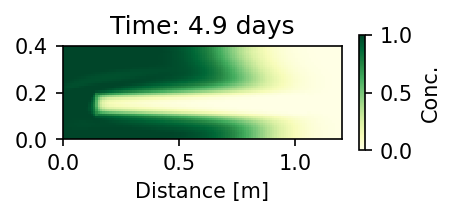

(40, 120)


(None,)

In [11]:
ts_plot = 6   
plot_2d(np.squeeze(conc[ts_plot,:,:,:]), delr, delv, colorbar_label='Conc.', cmap='YlGn', title='Time: %1.1f days' %(times[ts_plot]), clim=[0,1])
c1 = conc[ 6,:,0,:];   c2 = pd.DataFrame(c1);     c2.to_csv ("06a(conc_t06_see'').csv");    # print(cr.shape),  # c    # [0, :20, 39]
d1 = conc[20,:,0,:];   d2 = pd.DataFrame(d1);     d2.to_csv ("06a(conc_t20_see'').csv");      print(d2.shape),  # d2    # [0, :20, 39]

Notice how we don't have much advection through the clay layer? The transport into this layer is largely diffusive.

## **Breakthrough curve**

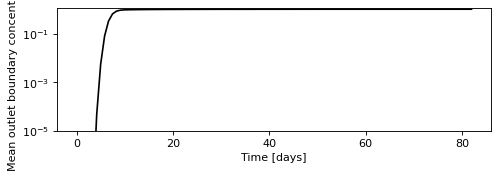

(103, 4800)


In [12]:
C_btc_model = np.mean([conc[:, 0, :, -1]], axis=2)                             ; plt.figure(figsize=(7, 2), dpi=80)
plt.plot(times, np.transpose(C_btc_model), 'k', label='')                      ; plt.yscale('log') 
plt.xlabel('Time [days]'); plt.ylabel('Mean outlet boundary concentration')    ; plt.ylim([1E-5, 1.2]); plt.show()
Cr = conc.reshape(conc.shape[0],  -1);   Cs = pd.DataFrame(Cr);      Cs.to_csv ("07_C_all.csv") ; print(Cr.shape)   # 20*40=800

## **..there is some long-term transport of solute as it is diffused from the clay layer = 'tailing'!** 

**_coarse, ... med, ...**

In [13]:
nlay = 8 ; nrow = 1 ; ncol = 24                    ; delv = 0.05 ; delr = 0.05 ; delc = 0.03 
material_location = np.zeros([nlay, nrow, ncol])   ; material_location[2:4, :, 3:-3] = 1  ; 
Hk = np.ones([nlay, nrow, ncol])*ksand             ;  Hk[material_location==1] = kclay
Por = np.ones([nlay, nrow, ncol])*por_sand         ; Por[material_location==1] = por_clay

.\backdiff\Chapman_model_coarse
Simulation ran to requested model time.


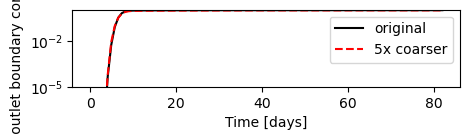

(103, 192)


In [14]:
dirname = 'Chapman_model_coarse'; heads_c, htimes_c, conc_c, times_c = model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv)
C_btc_model_c = np.mean([conc_c[:, 0, :, -1]], axis=2) ; 
plt.figure(figsize=(5, 1), dpi=100); plt.plot(times, np.transpose(C_btc_model), 'k', label='original'); 
plt.plot(times_c, np.transpose(C_btc_model_c), '--r', label='5x coarser'); plt.legend(); plt.yscale('log')
plt.xlabel('Time [days]');plt.ylabel('Mean outlet boundary concentration'); plt.ylim([1E-5, 1.1]); plt.show()
Cr_c = conc_c.reshape(conc_c.shape[0],  -1);   Cs_c = pd.DataFrame(Cr_c);      Cs_c.to_csv ("07_C_all_coarse.csv") ; print(Cs_c.shape)   # 20*40=800

In [15]:
nlay = 20; nrow = 1 ;   ncol = 40               ;  delv = 0.01;  delr = 0.01 ; delc = 0.03     # 20*60=1200  20*40=800  10*80
material_location = np.zeros([nlay, nrow, ncol])
material_location[5:10, :, 7:-8] = 1            ;     # plot_2d(np.squeeze(material_location), delr, delv, cmap='PiYG')
Hk = np.ones([nlay, nrow, ncol])*ksand          ;     Hk[material_location==1] = kclay
Por = np.ones([nlay, nrow, ncol])*por_sand      ;     Por[material_location==1] = por_clay

.\backdiff\Chapman_model_med
Simulation ran to requested model time.


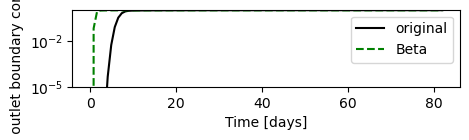

(103, 800)


In [16]:
dirname = 'Chapman_model_med'; heads_m, htimes_m, conc_m, times_m = model_2D(dirname, perlen_mt, Hk, Por, Q, Cinj, D0, nprs, delr, delc, delv)
C_btc_model_m = np.mean([conc_m[:, 0, :, -1]], axis=2)
plt.figure(figsize=(5, 1), dpi=100); plt.plot(times, np.transpose(C_btc_model), 'k', label='original')
# plt.plot(times_c, np.transpose(C_btc_model_c), '--r', label='5x coarser')
plt.plot(times_m, np.transpose(C_btc_model_m), '--g', label='Beta')
plt.legend(); plt.yscale('log'); plt.xlabel('Time [days]'); plt.ylabel('Mean outlet boundary concentration')
plt.ylim([1E-5, 1.1]); plt.show()
Cr_m = conc_m.reshape(conc_m.shape[0],  -1);   Cs_m = pd.DataFrame(Cr_m);      Cs_m.to_csv ("07_C_all_m.csv") ; print(Cs_m.shape)   # 20*40=800

We can see that going a little coarser still captures most of the tailing behavior and therefore is probably sufficient.

In [17]:
model_time = np.cumsum(perlen_mt)
D = pd.DataFrame(model_time); D.to_csv("07_B(Time)_y.csv")

In [18]:
 print(times.shape)

(103,)


In [19]:
 Cs_m = pd.DataFrame(times);      Cs_m.to_csv ("08_times.csv")